<a href="https://colab.research.google.com/github/khadijaraza/spisproject/blob/main/data_refinement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 78.0 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=8d03e74195db851fd99c93d1f236f369c37c6ab2cd105e74fa9f69ef4284b1b7
  Stored in directory: /root/.cache/pip/wheels/04/15/cd/2f622795b09e83471a3be5d2581cd9cf96a6ec7aa78e8deffe
  Created wheel for memoization: 

In [16]:
import lightkurve as lk
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

In [27]:
try:
    print("Searching for data in TESS...")
    search_result = lk.search_lightcurve(SkyCoord.from_name("Galactic Center"), mission='TESS', radius=0.25*u.degree)

    #print("Filtering for 600s exposure time...")
    #filtered_results = search_result[search_result.exptime.value == 600]
    filtered_results = search_result

    print(f"Found {len(filtered_results)} light curves. Downloading...")
    lc_collection = filtered_results.download_all()
    print("Download complete.")

except Exception as e:
    print(f"An error occurred during download: {e}")
    lc_collection = None

Searching for data in TESS...
Found 1020 light curves. Downloading...
Download complete.


In [29]:
from collections import defaultdict

def condenseData(lc_collection):

  #Group light curves by their unique target ID
  target_groups = defaultdict(list)
  for lc in lc_collection:
      target_groups[lc.TARGETID].append(lc)

  print(f"Found {len(lc_collection)} observation files for {len(target_groups)} unique celestial bodies.")

  #Create a new list of stitched light curves
  stitched_lightcurves_list = []
  for target_id, lc_list in target_groups.items():
      # Create a collection for just this one star's data
      single_body = lk.LightCurveCollection(lc_list)

      # Stitch all observations for this star into a single light curve
      stitched_lightcurves_list.append(single_body.stitch())

  print(f"Created a new list with {len(stitched_lightcurves_list)} stitched light curves.")
  return stitched_lightcurves_list

In [30]:
def preprocess_lightcurve(lc):
    try:
        clean_lc = lc.remove_nans().flatten(window_length=801).remove_outliers(sigma=5)
        bls = clean_lc.to_periodogram(method='bls', period=np.arange(1, 20, 0.01))
        period = bls.period_at_max_power
        folded_lc = clean_lc.fold(period=period)
        binned_lc = folded_lc.bin(time_bin_size=0.01).normalize()
        return binned_lc
    except Exception:
        return None, None

In [31]:
stitched_lightcurves_list = condenseData(lc_collection)

# Process each stitched light curve with its specific periodz
processed_lcs = []
for lc in stitched_lightcurves_list:
    processed_lc = preprocess_lightcurve(lc)
    if processed_lc is not None:
        print(f"Processing TIC {lc.TARGETID} ")
        processed_lcs.append(processed_lc)
    else:
        print(f"Skipping TIC {lc.TARGETID} due to processing error.")

Found 100 observation files for 48 unique celestial bodies.


/usr/local/lib/python3.12/dist-packages/lightkurve/lightcurve.py:1154: LightkurveWarning: The light curve appears to be zero-centered (median=1.00e+00 +/- 2.44e+00); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lightkurve/lightcurve.py:1154: LightkurveWarning: The light curve appears to be zero-centered (median=1.00e+00 +/- 2.10e+00); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lightkurve/lightcurve.py:1154: LightkurveWarning: The light curve appears to be zero-centered (median=4.02e+00 electron / s +/- 1.65e+01 electron / s); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lightkurve/lightcurve.py:1154: LightkurveWarning: The light curve appe

Created a new list with 48 stitched light curves.
Processing TIC 321993524 
Processing TIC 321993694 
Processing TIC 321994061 
Processing TIC 321994071 
Processing TIC 321993360 
Processing TIC 204215688 
Processing TIC 1427464565 
Processing TIC 204215677 
Processing TIC 321993022 
Processing TIC 321994441 
Processing TIC 321992729 
Processing TIC 321994067 
Processing TIC 321992885 
Processing TIC 204216533 
Processing TIC 321994735 
Processing TIC 204216693 
Processing TIC 204215262 
Processing TIC 321994182 
Processing TIC 321994814 
Processing TIC 321993890 
Processing TIC 321992309 
Processing TIC 1427460328 
Processing TIC 321994484 
Processing TIC 321992639 
Processing TIC 321992041 
Processing TIC 321993936 
Processing TIC 204214953 
Processing TIC 321995114 
Processing TIC 321993489 
Processing TIC 321995275 
Processing TIC 321992075 
Processing TIC 321991816 
Processing TIC 321995185 
Processing TIC 321994016 
Processing TIC 321995138 
Processing TIC 1427464126 
Processing 

/usr/local/lib/python3.12/dist-packages/lightkurve/lightcurve.py:1987: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1)


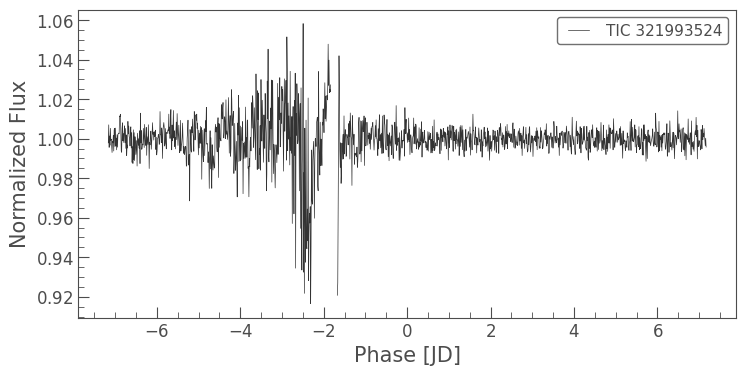

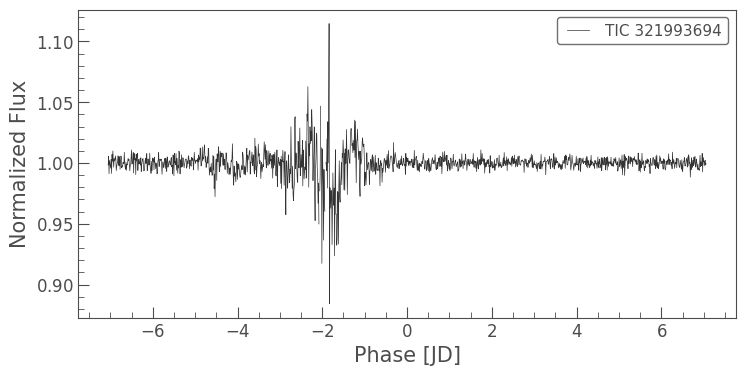

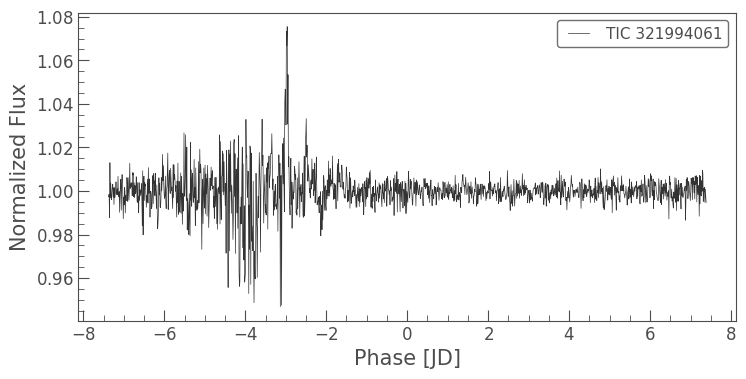

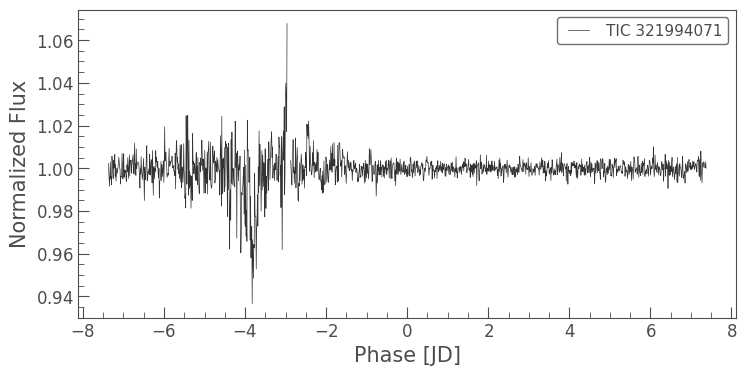

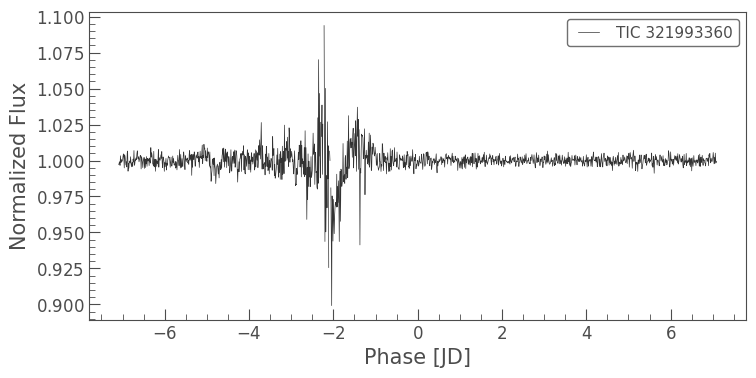

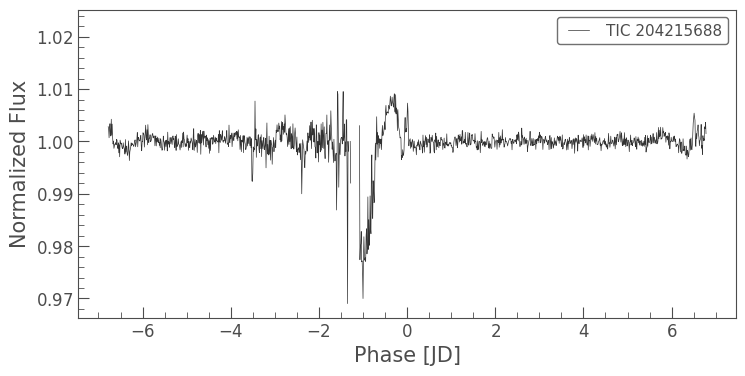

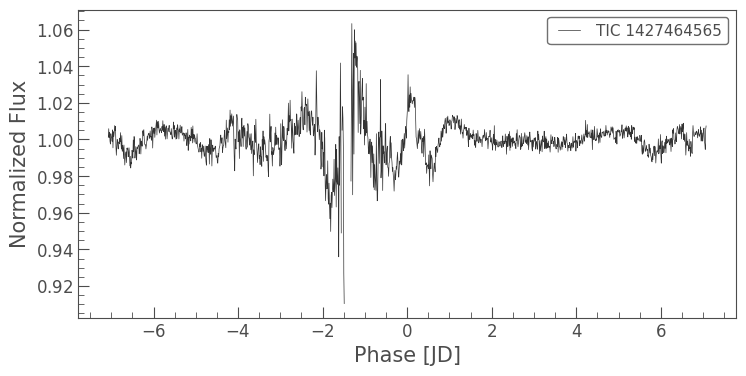

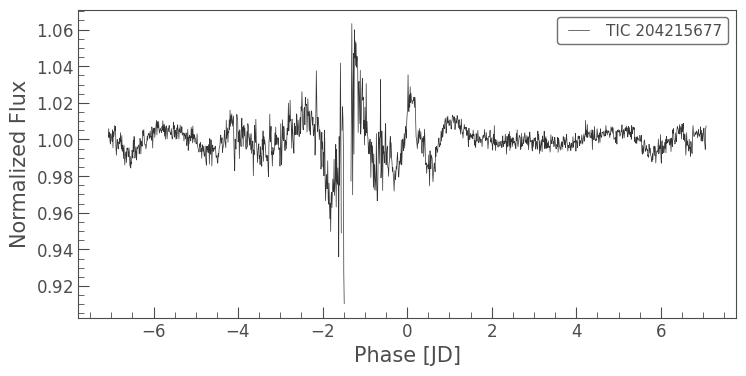

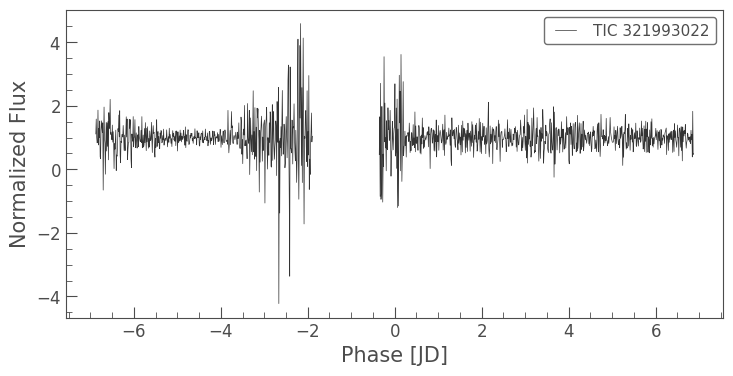

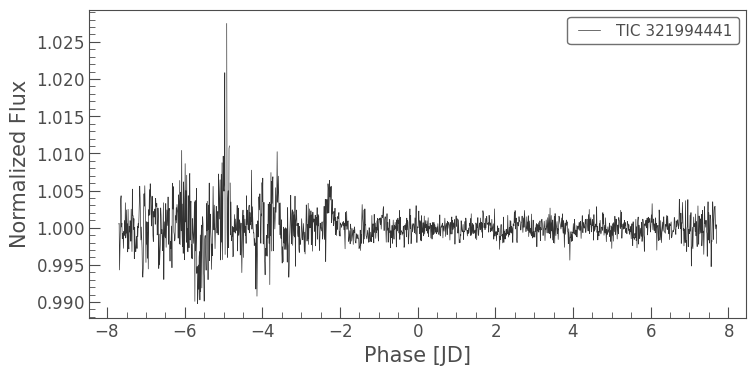

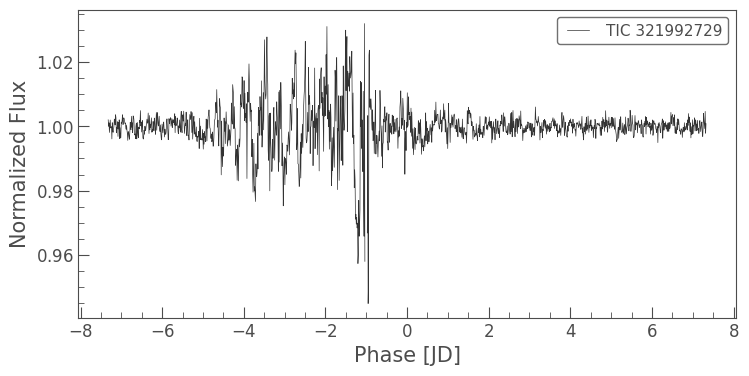

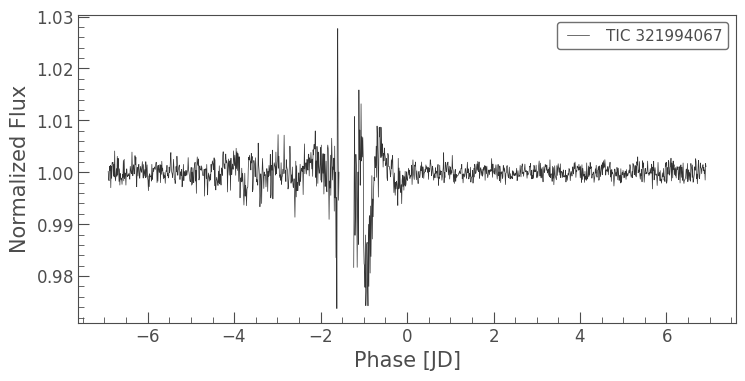

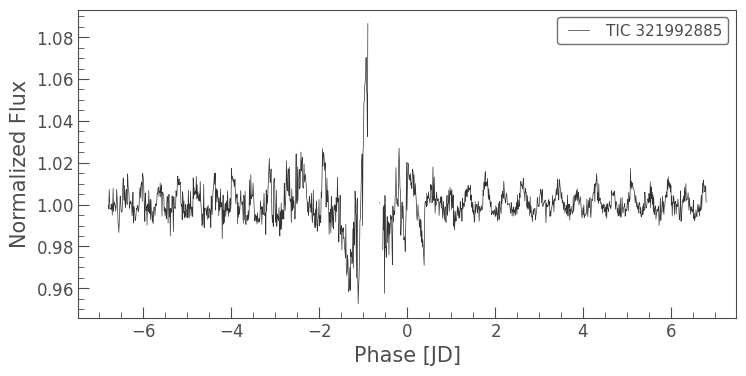

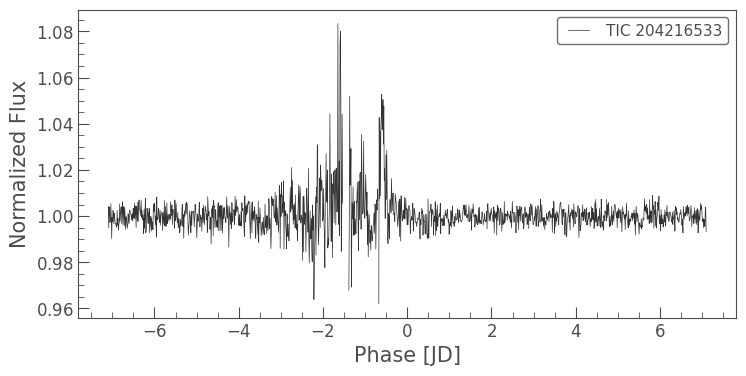

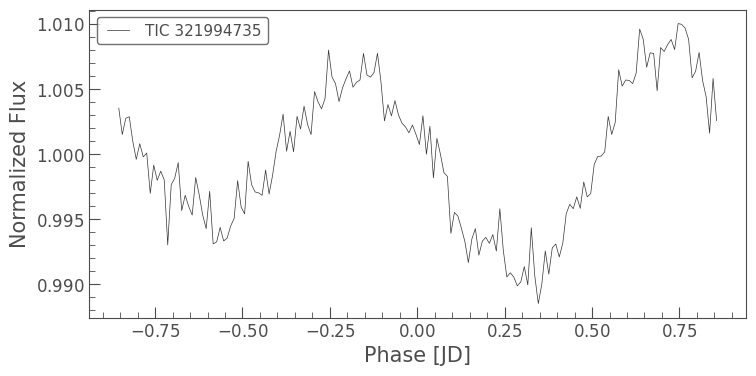

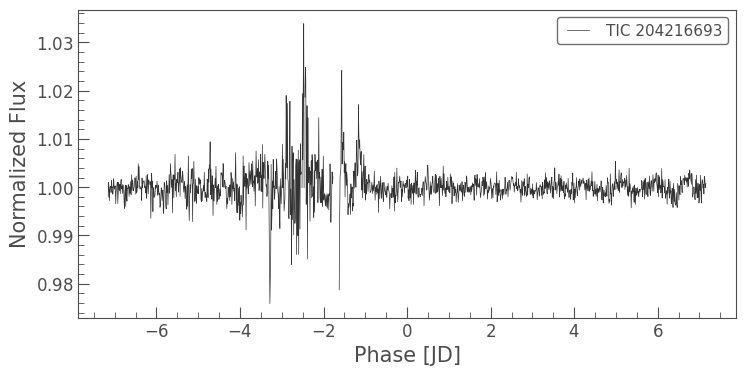

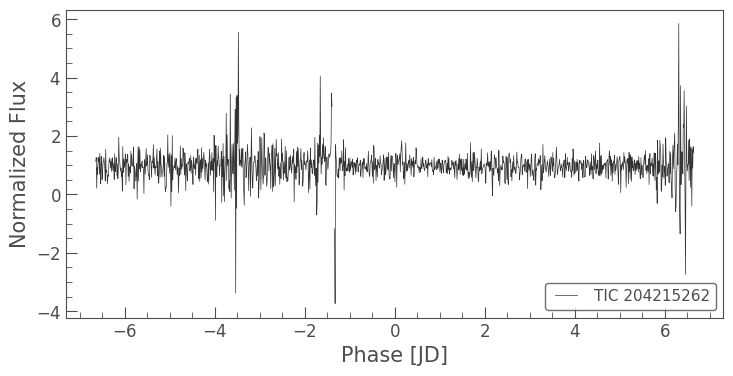

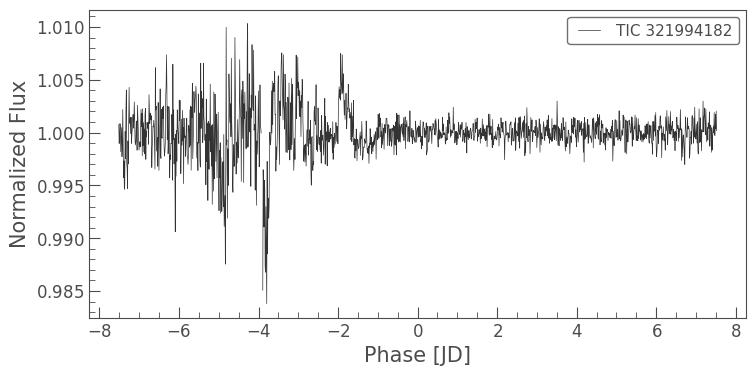

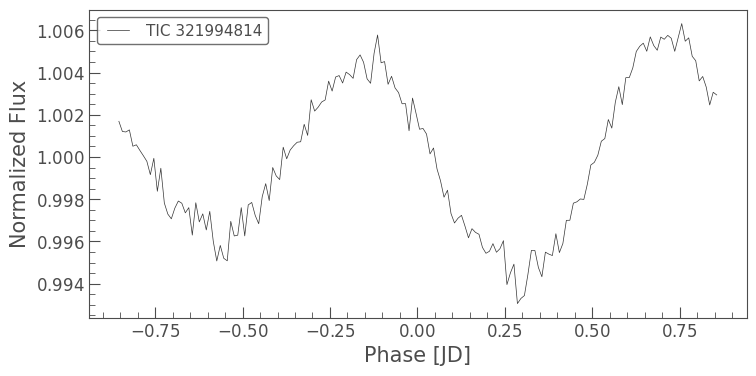

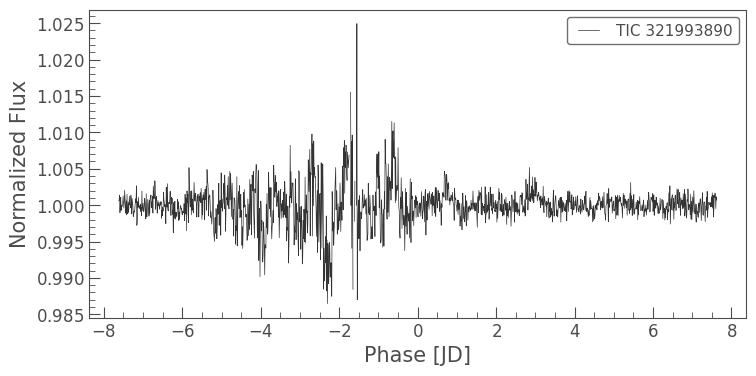

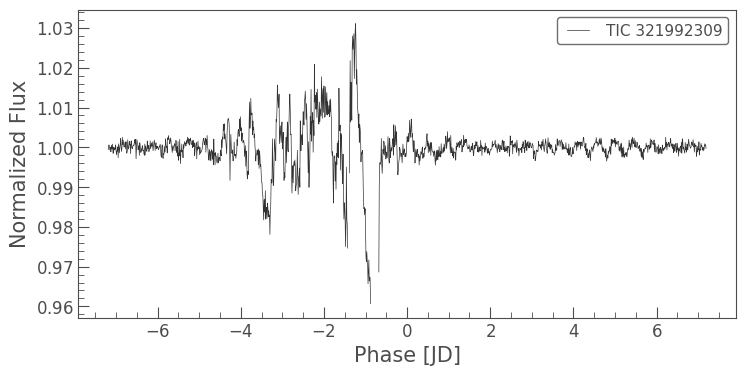

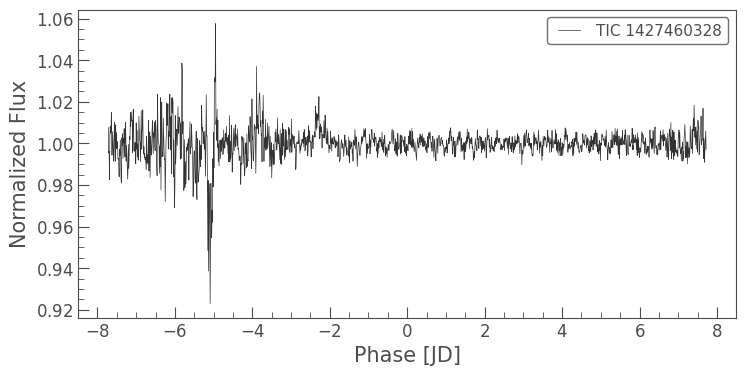

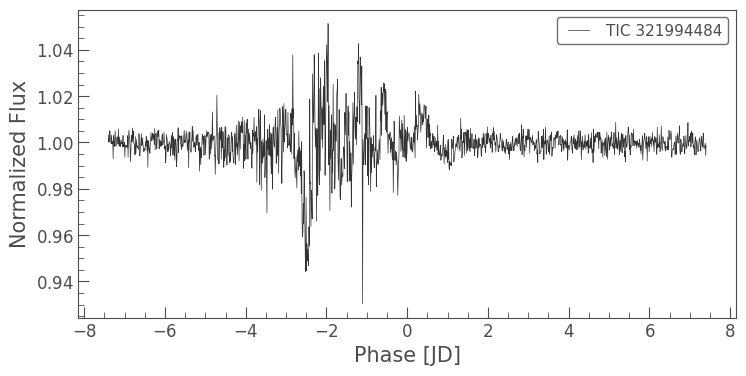

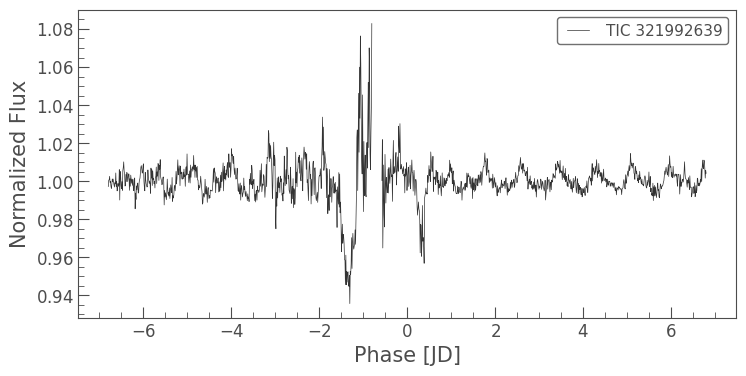

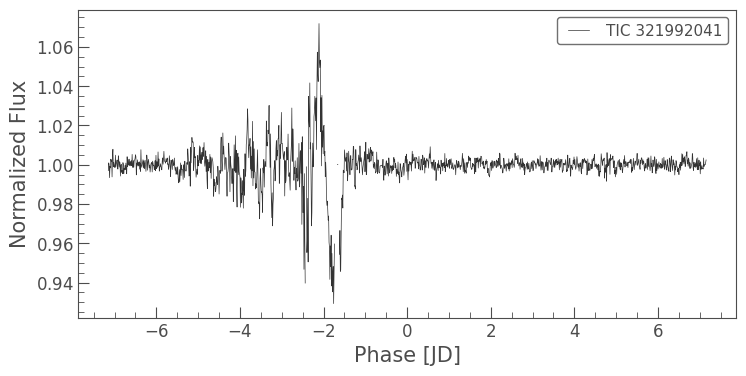

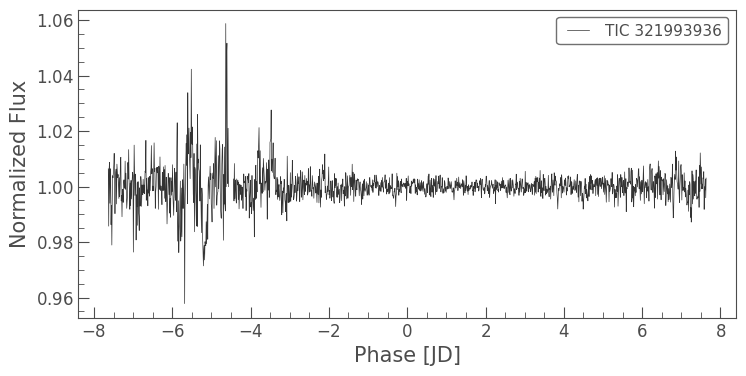

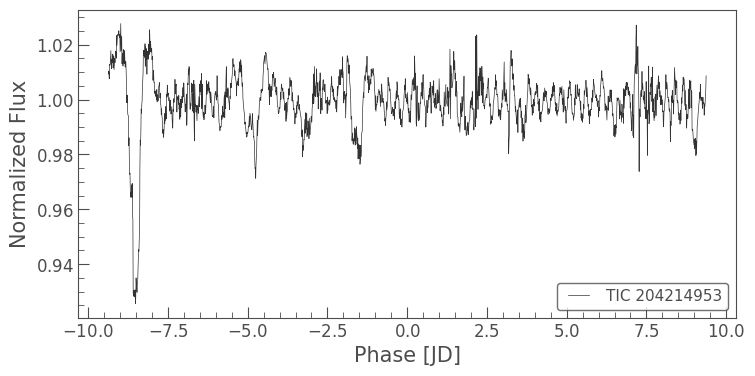

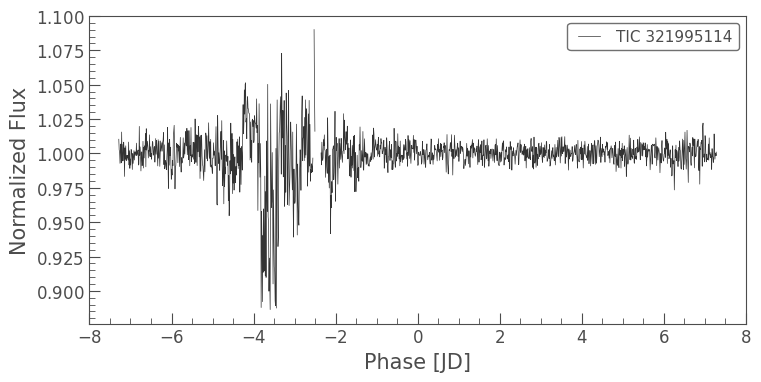

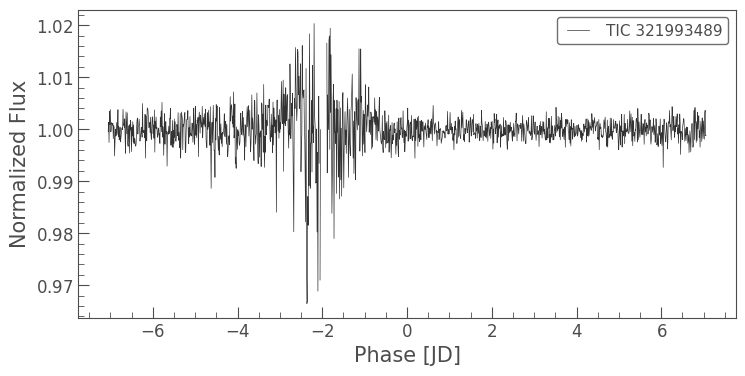

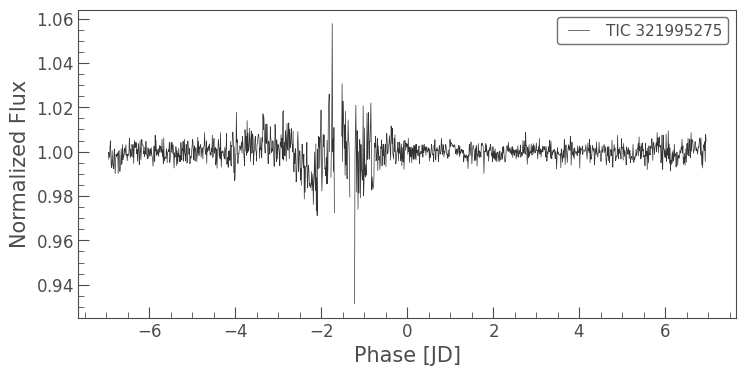

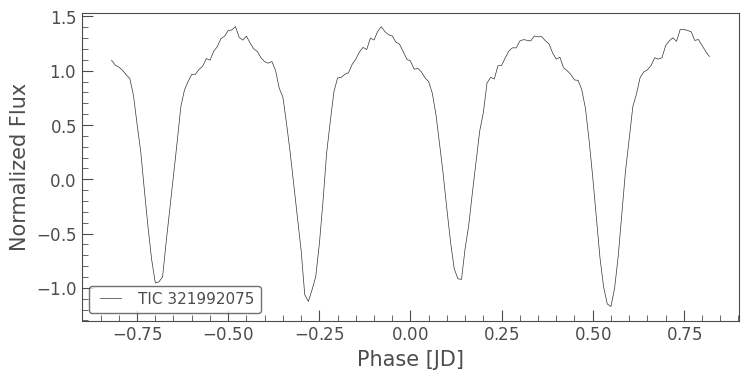

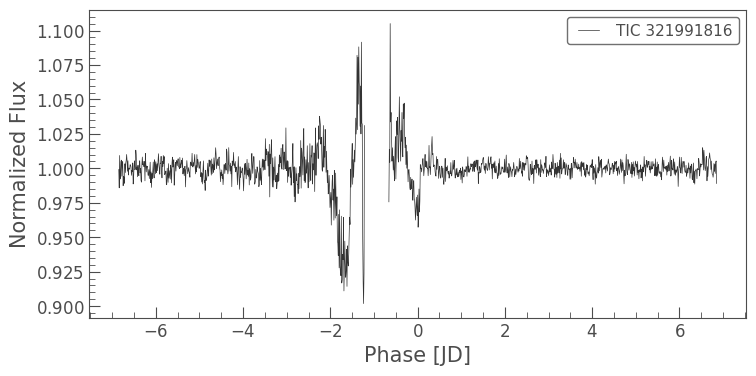

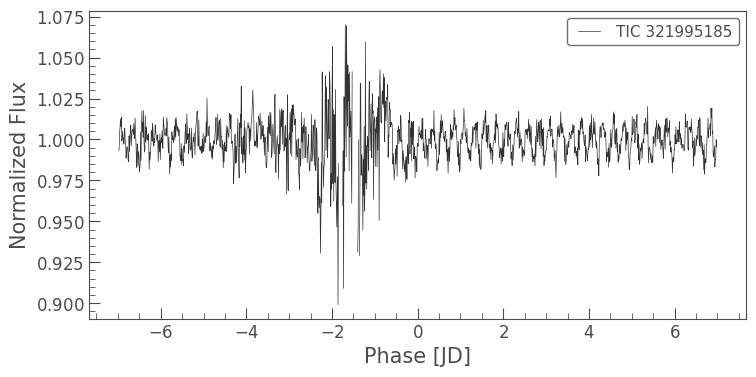

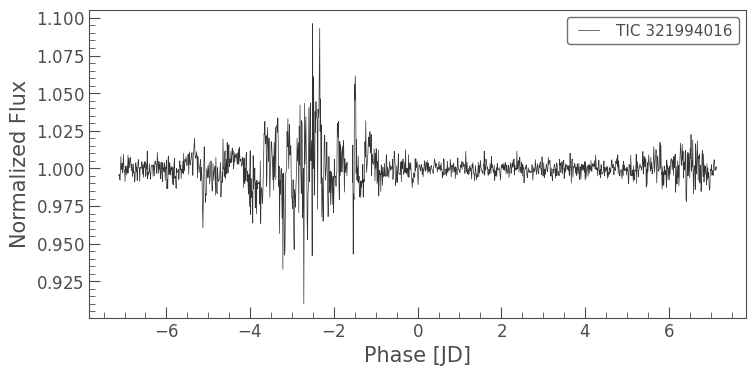

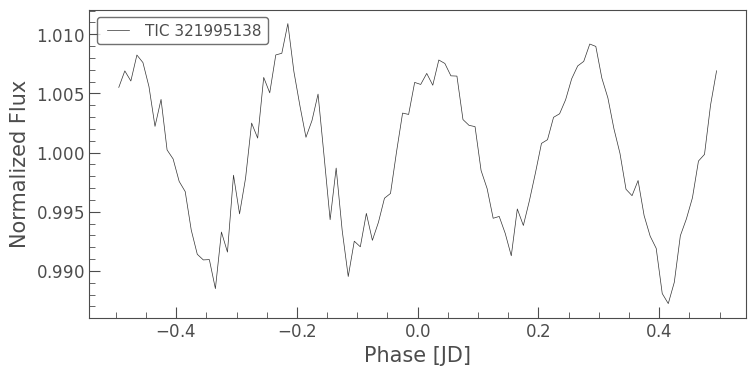

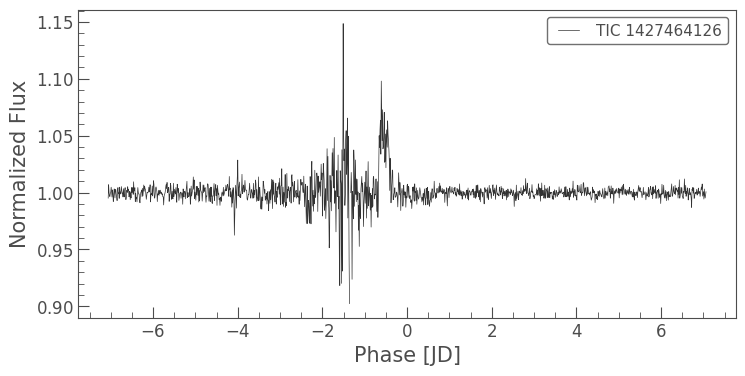

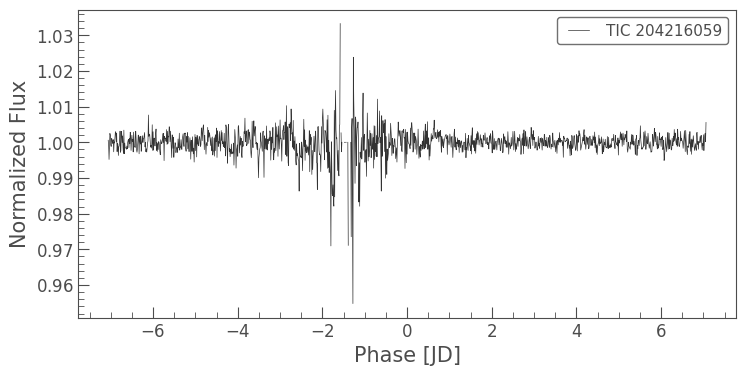

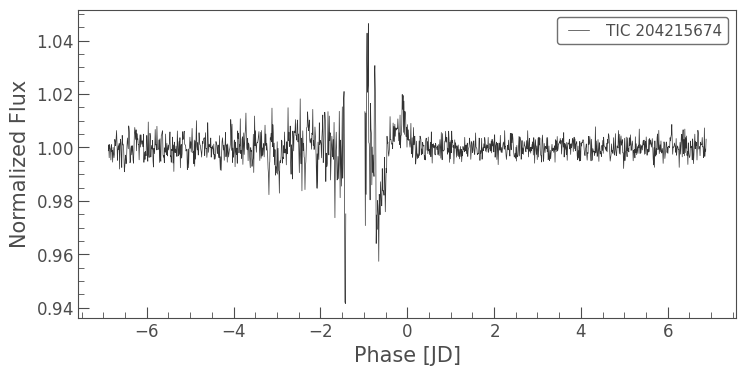

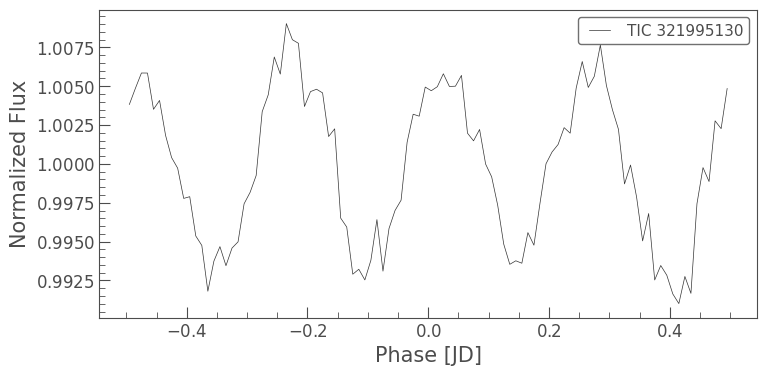

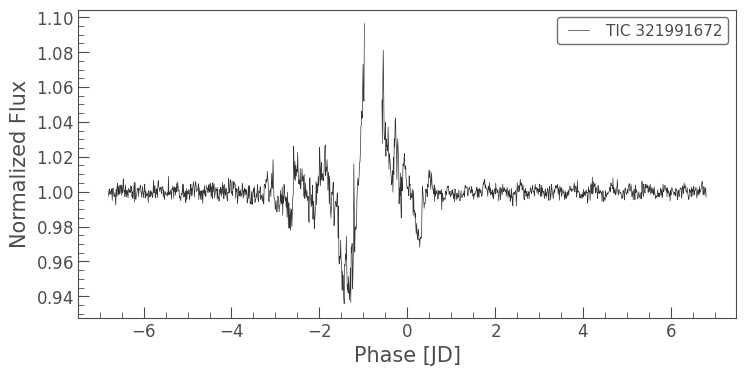

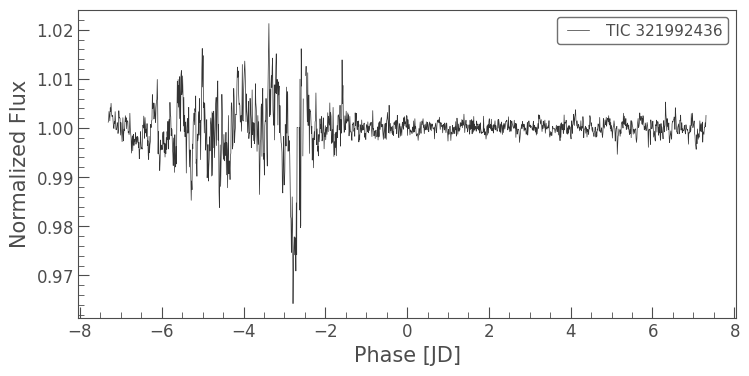

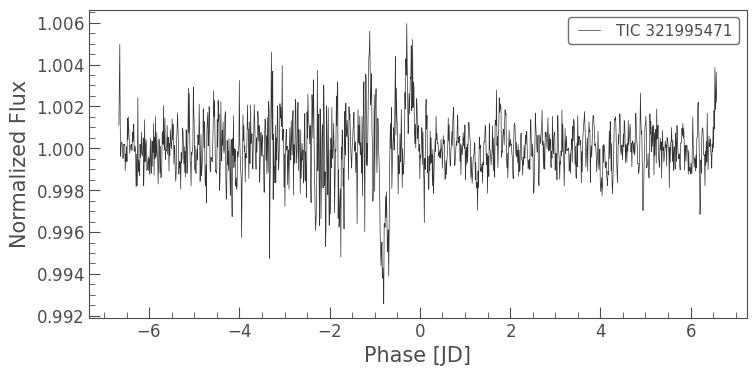

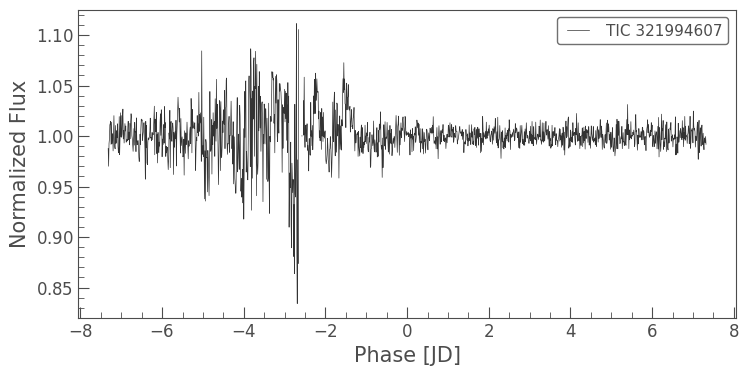

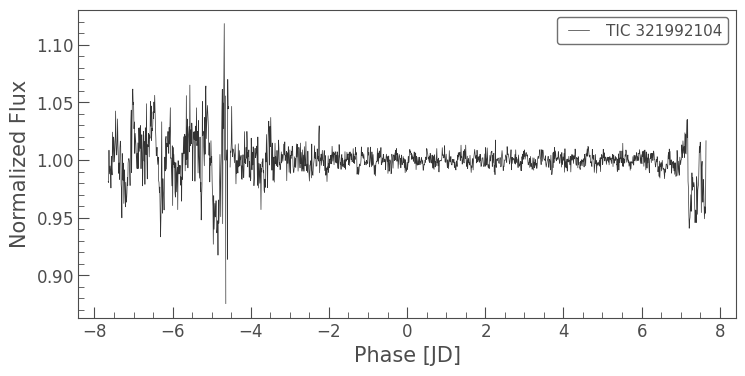

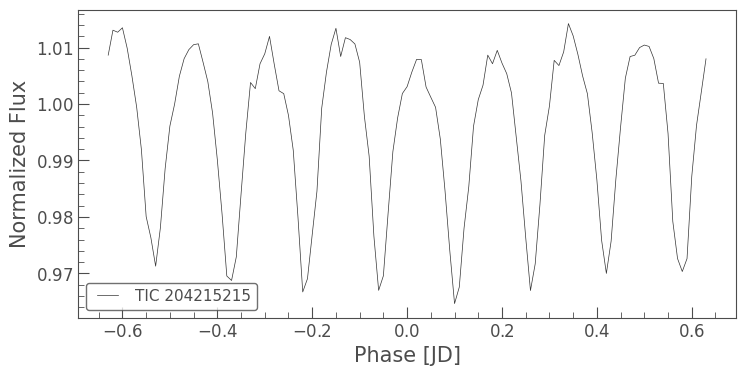

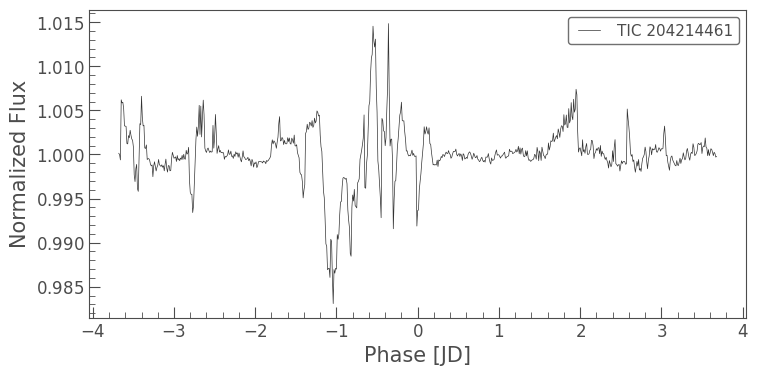

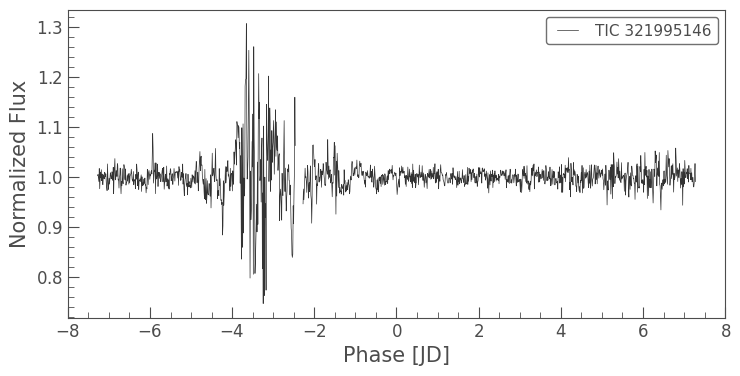

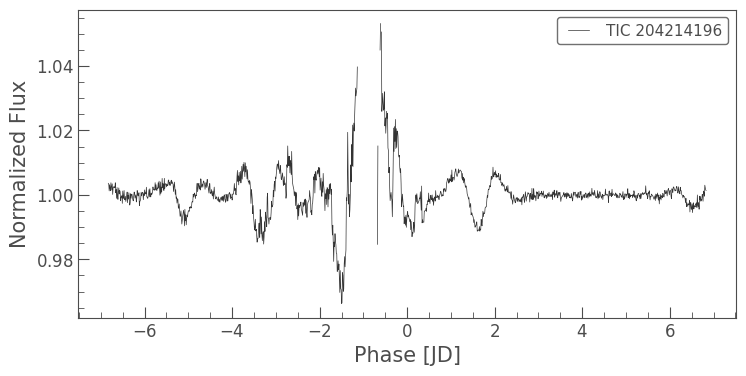

In [32]:
for lc in processed_lcs:
    lc.plot()